In [1]:
import pandas as pd
import numpy as np  
from sklearn.experimental import enable_iterative_imputer  # Enable IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing Data

In [3]:
# Load Data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
data_dict = pd.read_csv('data_dictionary.csv')

# Data Preparation

In [5]:
# Get Statistical details
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Basic_Demos-Age,3960.0,10.433586,3.574648,5.0,8.00000,10.000000,13.000000,22.000000
Basic_Demos-Sex,3960.0,0.372727,0.483591,0.0,0.00000,0.000000,1.000000,1.000000
CGAS-CGAS_Score,2421.0,65.454771,22.341862,25.0,59.00000,65.000000,75.000000,999.000000
Physical-BMI,3022.0,19.331929,5.113934,0.0,15.86935,17.937682,21.571244,59.132048
Physical-Height,3027.0,55.946713,7.473764,33.0,50.00000,55.000000,62.000000,78.500000
...,...,...,...,...,...,...,...,...
PCIAT-PCIAT_Total,2736.0,27.896199,20.338853,0.0,12.00000,26.000000,41.000000,93.000000
SDS-SDS_Total_Raw,2609.0,41.088923,10.427433,17.0,33.00000,39.000000,46.000000,96.000000
SDS-SDS_Total_T,2606.0,57.763622,13.196091,38.0,47.00000,55.000000,64.000000,100.000000
PreInt_EduHx-computerinternet_hoursday,3301.0,1.060588,1.094875,0.0,0.00000,1.000000,2.000000,3.000000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [7]:
data_dict.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


## EDA

Class Distribution:
 sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64


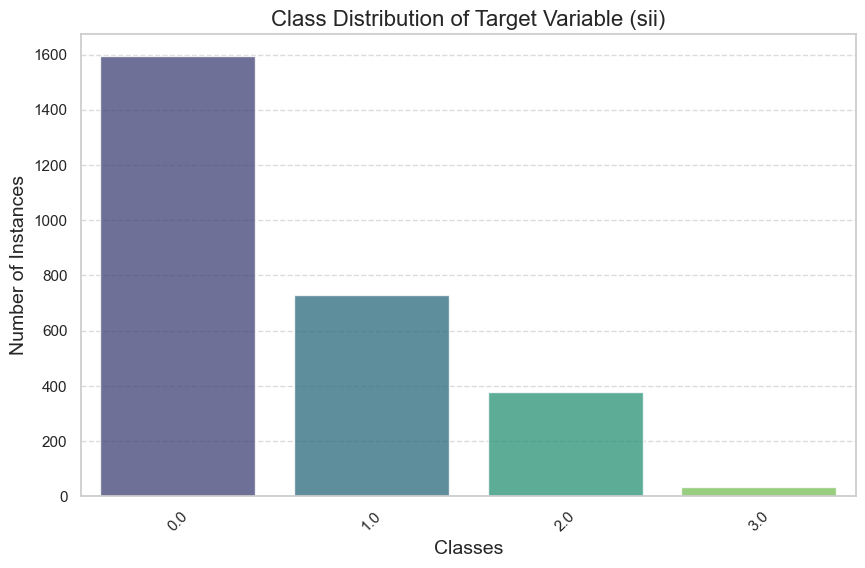

In [9]:
# Check the distribution of the target variable 'sii'
class_distribution = train_df['sii'].value_counts().sort_index()
print("Class Distribution:\n", class_distribution)

# Set the style for the plot
sns.set(style="whitegrid")

# Create a bar plot of class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis', alpha=0.8)

# Set the title and labels
plt.title('Class Distribution of Target Variable (sii)', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: add gridlines for better readability

# Show the plot
plt.show()

In [10]:
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

In [11]:
train_df['Age Group'] = pd.cut(
    train_df['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)
calculate_stats(train_df, 'Age Group')

,count (%)
Age Group,
Children (5-12),2919 (73.71%)
Adolescents (13-18),953 (24.07%)
Adults (19-22),88 (2.22%)


In [12]:
sex_counts_renamed = train_df['Basic_Demos-Sex'].replace({0: 'Male', 1: 'Female'}).value_counts()
sex_counts_renamed

Basic_Demos-Sex
Male      2484
Female    1476
Name: count, dtype: int64

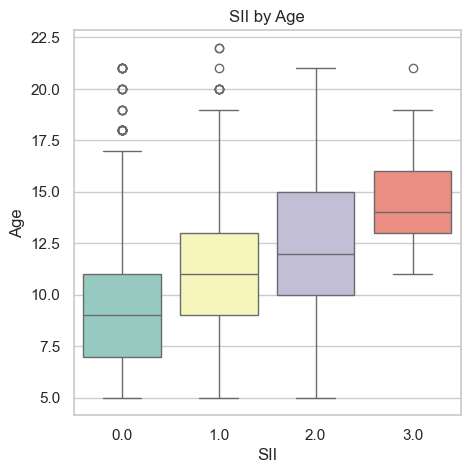

In [13]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(5, 5)) 

# Create the boxplot for SII by Age with hue
sns.boxplot(y=train_df['Basic_Demos-Age'], x=train_df['sii'], ax=ax, hue=train_df['sii'], palette="Set3", legend=False)  # Pass ax directly

# Set the title and labels
ax.set_title('SII by Age')  # Set the title on the ax object
ax.set_ylabel('Age')  # Set the y-axis label
ax.set_xlabel('SII')  # Set the x-axis label

# Show the plot
plt.show()

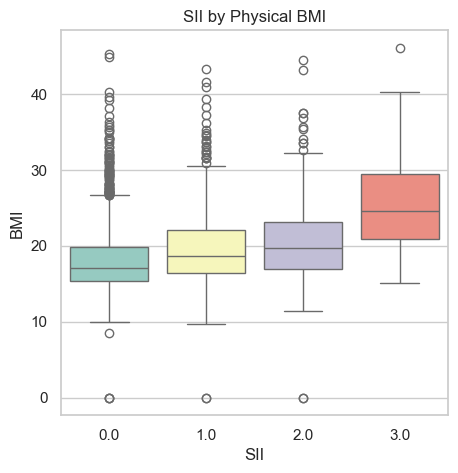

In [14]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(5, 5))  # Use ax instead of axes
sns.boxplot(y=train_df['Physical-BMI'], x=train_df['sii'], ax=ax, palette="Set3")  # Pass ax directly

# Set the title and labels
ax.set_title('SII by Physical BMI')  # Update the title appropriately
ax.set_ylabel('BMI')  # Set the y-axis label
ax.set_xlabel('SII')  # Set the x-axis label

# Show the plot
plt.show()

---

# Data Preprocessing

### Check for Duplicate Data

In [18]:
train_df.duplicated().sum()

0

There are no duplicates in this data.

### Missing Values

In [21]:
train_df.isnull()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Age Group
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,False,False,False,False
1,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3956,False,False,False,False,True,True,False,False,False,False,...,True,True,True,True,True,True,False,False,True,False
3957,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3958,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
train_df.isnull().sum()

id                                           0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
                                          ... 
SDS-SDS_Total_T                           1354
PreInt_EduHx-Season                        420
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Age Group                                    0
Length: 83, dtype: int64

In [23]:
# Calculate missing values by columns
def check_missing_values(row):
    """ functions that check and verifies if there are missing values in dataframe """
    counter = 0
    for element in row:
        if element == True:
            counter+=1
    return ("The amount of missing records is: ", counter)
    
train_df.isnull().apply(lambda x: check_missing_values(x))

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Age Group
0,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,...,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:
1,0,0,0,0,1405,1539,650,938,933,884,...,1230,1227,1224,1342,1351,1354,420,659,1224,0


In [24]:
# Calculate missing values in every record
train_df.isnull().apply(lambda x: check_missing_values(x), axis=1)

0       (The amount of missing records is: , 19)
1       (The amount of missing records is: , 12)
2       (The amount of missing records is: , 20)
3        (The amount of missing records is: , 7)
4       (The amount of missing records is: , 75)
                          ...                   
3955     (The amount of missing records is: , 7)
3956    (The amount of missing records is: , 54)
3957     (The amount of missing records is: , 7)
3958    (The amount of missing records is: , 21)
3959    (The amount of missing records is: , 74)
Length: 3960, dtype: object

### 1. Encoding Seasons as Numbers

In [26]:
train_df

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Age Group
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,Children (5-12)
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,Children (5-12)
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,Children (5-12)
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0,Children (5-12)
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adolescents (13-18)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0,Adolescents (13-18)
3956,ffa9794a,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,NaN,Children (5-12)
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0,Children (5-12)
3958,ffed1dd5,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,...,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0.0,Adolescents (13-18)


In [27]:
# Check for unique values
print(train_df['Basic_Demos-Enroll_Season'].unique())

['Fall' 'Summer' 'Winter' 'Spring']


In [28]:
# Display columns containing 'Season'
season_columns = [col for col in train_df.columns if 'Season' in col]
print("Columns containing 'Season':", season_columns)

Columns containing 'Season': ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']


In [29]:
season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
for column in season_columns:
    train_df[column] = train_df[column].map(season_mapping)

In [30]:
train_df

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Age Group
0,00008ff9,3,5,0,4.0,51.0,3.0,16.877316,46.0,50.8,...,2.0,4.0,55.0,NaN,NaN,NaN,3.0,3.0,2.0,Children (5-12)
1,000fd460,2,9,0,NaN,NaN,3.0,14.035590,48.0,46.0,...,0.0,0.0,0.0,3.0,46.0,64.0,2.0,0.0,0.0,Children (5-12)
2,00105258,2,10,1,3.0,71.0,3.0,16.648696,56.5,75.6,...,1.0,1.0,28.0,3.0,38.0,54.0,2.0,2.0,0.0,Children (5-12)
3,00115b9f,4,9,0,3.0,71.0,2.0,18.292347,56.0,81.6,...,4.0,1.0,44.0,2.0,31.0,45.0,4.0,0.0,1.0,Children (5-12)
4,0016bb22,1,18,1,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adolescents (13-18)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,3,13,0,1.0,60.0,3.0,16.362460,59.5,82.4,...,1.0,0.0,32.0,4.0,35.0,50.0,3.0,1.0,1.0,Adolescents (13-18)
3956,ffa9794a,4,10,0,NaN,NaN,1.0,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,Children (5-12)
3957,ffcd4dbd,3,11,0,1.0,68.0,4.0,21.441500,60.0,109.8,...,0.0,1.0,31.0,4.0,56.0,77.0,3.0,0.0,1.0,Children (5-12)
3958,ffed1dd5,1,13,0,1.0,70.0,4.0,12.235895,70.7,87.0,...,1.0,1.0,19.0,1.0,33.0,47.0,1.0,1.0,0.0,Adolescents (13-18)


### Drop 'id' column for training

In [32]:
# target
train_df["sii"].value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

In [33]:
train_df

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Age Group
0,00008ff9,3,5,0,4.0,51.0,3.0,16.877316,46.0,50.8,...,2.0,4.0,55.0,NaN,NaN,NaN,3.0,3.0,2.0,Children (5-12)
1,000fd460,2,9,0,NaN,NaN,3.0,14.035590,48.0,46.0,...,0.0,0.0,0.0,3.0,46.0,64.0,2.0,0.0,0.0,Children (5-12)
2,00105258,2,10,1,3.0,71.0,3.0,16.648696,56.5,75.6,...,1.0,1.0,28.0,3.0,38.0,54.0,2.0,2.0,0.0,Children (5-12)
3,00115b9f,4,9,0,3.0,71.0,2.0,18.292347,56.0,81.6,...,4.0,1.0,44.0,2.0,31.0,45.0,4.0,0.0,1.0,Children (5-12)
4,0016bb22,1,18,1,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adolescents (13-18)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,3,13,0,1.0,60.0,3.0,16.362460,59.5,82.4,...,1.0,0.0,32.0,4.0,35.0,50.0,3.0,1.0,1.0,Adolescents (13-18)
3956,ffa9794a,4,10,0,NaN,NaN,1.0,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,Children (5-12)
3957,ffcd4dbd,3,11,0,1.0,68.0,4.0,21.441500,60.0,109.8,...,0.0,1.0,31.0,4.0,56.0,77.0,3.0,0.0,1.0,Children (5-12)
3958,ffed1dd5,1,13,0,1.0,70.0,4.0,12.235895,70.7,87.0,...,1.0,1.0,19.0,1.0,33.0,47.0,1.0,1.0,0.0,Adolescents (13-18)


### 2. Predict Missing Values

In [35]:
# Impute missing values
imputer = IterativeImputer(random_state=42)
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train_df[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)

# Convert the 'sii' column back to integers and ensure it stays between 0 and 3
if 'sii' in numeric_cols:
    train_imputed['sii'] = train_imputed['sii'].clip(lower=0, upper=3).round().astype(int)

# Convert any numeric columns in season_columns to integers
for column in season_columns:
    if column in train_imputed.columns:
        train_imputed[column] = train_imputed[column].round().astype(int)

# Retain other columns from the original DataFrame
for col in train_df.columns:
    if col not in numeric_cols:
        train_imputed[col] = train_df[col]

In [36]:
train_imputed

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,id,Age Group
0,3,5.0,0.0,4,51.000000,3,16.877316,46.000000,50.800000,26.118428,...,4.000000,55.000000,3,40.886290,58.006048,3,3.000000,2,00008ff9,Children (5-12)
1,2,9.0,0.0,3,59.171114,3,14.035590,48.000000,46.000000,22.000000,...,0.000000,0.000000,3,46.000000,64.000000,2,0.000000,0,000fd460,Children (5-12)
2,2,10.0,1.0,3,71.000000,3,16.648696,56.500000,75.600000,31.728584,...,1.000000,28.000000,3,38.000000,54.000000,2,2.000000,0,00105258,Children (5-12)
3,4,9.0,0.0,3,71.000000,2,18.292347,56.000000,81.600000,33.431244,...,1.000000,44.000000,2,31.000000,45.000000,4,0.000000,1,00115b9f,Children (5-12)
4,1,18.0,1.0,2,65.720765,2,17.748072,61.541915,95.907395,26.877198,...,0.950426,27.718109,2,41.075903,57.701499,1,1.823857,1,0016bb22,Adolescents (13-18)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,3,13.0,0.0,1,60.000000,3,16.362460,59.500000,82.400000,26.689886,...,0.000000,32.000000,4,35.000000,50.000000,3,1.000000,1,ff8a2de4,Adolescents (13-18)
3956,4,10.0,0.0,2,58.989835,1,18.764678,53.500000,76.400000,27.000000,...,0.961339,27.976245,2,40.904892,57.638712,4,0.000000,0,ffa9794a,Children (5-12)
3957,3,11.0,0.0,1,68.000000,4,21.441500,60.000000,109.800000,27.947083,...,1.000000,31.000000,4,56.000000,77.000000,3,0.000000,1,ffcd4dbd,Children (5-12)
3958,1,13.0,0.0,1,70.000000,4,12.235895,70.700000,87.000000,26.145078,...,1.000000,19.000000,1,33.000000,47.000000,1,1.000000,0,ffed1dd5,Adolescents (13-18)


In [37]:
train_imputed.isnull().apply(lambda x: check_missing_values(x))

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,id,Age Group
0,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,...,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---

### Feature Engineering

### 3. Add variables
The dataset contains features related to physical characteristics (eg, BMI, Height, Weight), behavioral aspects (eg, internet usage), and fitness data (eg, endurance time).

In [40]:
# Feature Engineering
def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    
    # Calculate ratios
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    
    # Scale energy metrics relative to weight
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    
    # Standardize body metrics
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

In [41]:
# Apply feature engineering and clean data
train_imputed = feature_engineering(train_imputed)
train_imputed.dropna(thresh=1, axis=0, inplace=True)
train_imputed.replace([np.inf, -np.inf], 0, inplace=True)

# Impute test data
test_imputed = feature_engineering(test_df)
test_imputed.dropna(thresh=1, axis=0, inplace=True)
test_imputed.replace([np.inf, -np.inf], 0, inplace=True)

In [42]:
train_imputed

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW
0,3,5.0,0.0,4,51.000000,3,16.877316,46.000000,50.800000,26.118428,...,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.747453
1,2,9.0,0.0,3,59.171114,3,14.035590,48.000000,46.000000,22.000000,...,0.305154,1.458119,3719.320478,5950.914352,20.362087,32.579348,0.321056,12.718037,0.588157,0.777492
2,2,10.0,1.0,3,71.000000,3,16.648696,56.500000,75.600000,31.728584,...,0.656826,1.246361,8167.038404,13418.713631,16.362672,26.884411,0.749040,9.759206,0.714269,0.614336
3,4,9.0,0.0,3,71.000000,2,18.292347,56.000000,81.600000,33.431244,...,0.224196,1.281264,21298.377749,36207.411592,13.865564,23.571569,0.472854,6.274343,0.563684,0.661008
4,1,18.0,1.0,2,65.720765,2,17.748072,61.541915,95.907395,26.877198,...,0.171359,1.246361,31304.534660,47952.916020,12.898046,19.757486,0.710929,10.089245,0.563030,0.614336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,3,13.0,0.0,1,60.000000,3,16.362460,59.500000,82.400000,26.689886,...,0.198595,1.254711,13985.687504,23775.715110,14.646602,24.899272,0.500487,12.939628,0.641165,0.631642
3956,4,10.0,0.0,2,58.989835,1,18.764678,53.500000,76.400000,27.000000,...,1.105401,1.246360,4852.829583,8086.056947,16.191334,26.978909,0.549644,6.781037,0.706790,0.614336
3957,3,11.0,0.0,1,68.000000,4,21.441500,60.000000,109.800000,27.947083,...,0.195299,1.310804,42623.022658,68197.040233,11.418397,18.269490,0.479653,4.334530,0.496020,0.623919
3958,1,13.0,0.0,1,70.000000,4,12.235895,70.700000,87.000000,26.145078,...,0.140658,1.270142,-8357.575498,-17550.944000,16.256782,34.139310,0.642631,-54.662704,0.780503,0.609266


---

### 4. PCA

In [45]:
# PCA Implementation
common_columns = train_imputed.columns.intersection(test_imputed.columns)
X = train_imputed[common_columns].drop('id', axis=1) 
y = train_imputed['sii']  # target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [46]:
X_train_scaled.shape

(3168, 73)

In [47]:
X_train_pca.shape

(3168, 29)

In [48]:
# Ada Model

In [49]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# Fit the model on PCA-transformed training data
ada_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_ada = ada_model.predict(X_test_pca)

# Calculate accuracy
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f'AdaBoost Model Accuracy: {accuracy_ada:.4f}')

AdaBoost Model Accuracy: 0.5126


In [50]:
# Gradient Boost

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Fit the model on PCA-transformed training data
gb_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test_pca)

# Calculate accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Model Accuracy: {accuracy_gb:.4f}')

Gradient Boosting Model Accuracy: 0.6275


In [52]:
# Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fit the model on PCA-transformed training data
rf_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_pca)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Model Accuracy: {accuracy_rf:.4f}')

Random Forest Model Accuracy: 0.6553


In [54]:
# Voting Classifier

In [55]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Initialize the voting classifier with the three models
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('ada', ada_model),
        ('gb', gb_model)
    ],
    voting='soft'  # Use soft voting to consider predicted probabilities
)

# Fit the voting model on PCA-transformed training data
voting_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_voting = voting_model.predict(X_test_pca)

# Calculate accuracy
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f'Voting Classifier Model Accuracy: {accuracy_voting:.4f}')

Voting Classifier Model Accuracy: 0.6452
